In [1]:
%cd ..
%pwd

/home/quasar/GitHub/TradeForecast


/home/quasar/GitHub/TradeForecast/.venv/lib/python3.12/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


'/home/quasar/GitHub/TradeForecast'

In [2]:
from lightning.pytorch.loggers import TensorBoardLogger
from tradeforecast.augmentation import RNNDataset
from tradeforecast.viz import plot_rnn_forecasts
from tradeforecast.forecast.base import LitBase
from tradeforecast.forecast import calc_metrics
from torch.utils.data import DataLoader
from lightning import Trainer
from torch import Tensor
from torch import optim
import torch.nn.functional as F

def predict(model: LitBase, data_loader: DataLoader, dataset: RNNDataset):
    y: Tensor; y_pred: Tensor
    y, y_pred = model.predict(data_loader)
    metrics = calc_metrics(y, y_pred)
    y = dataset.inverse_transform(y.numpy())
    y_pred = dataset.inverse_transform(y_pred.numpy())
    plot_rnn_forecasts(model, y, y_pred)
    return metrics

ticker = 'GOOG' # slecet a stock of interest to perform analysis
interval = '1d' # interval for historical data 
start_date = '2015-01-01' # start date of historical data
end_date = '2024-12-06' # end date of historical data

logs_dir = 'tensorboard_logs'
epochs = 1000
batch_size = 128
num_workers = 10

metrics = {'model':[], 'train_loss':[], 'test_loss':[], 'MAE':[], 'MSE':[], 'RMSE':[], 'R-squared':[]}

In [3]:
from tradeforecast.augmentation import DataEntryPoint, Indicators, FeatureEngg
from tradeforecast.scrape import Scrapper

scrapper = Scrapper(ticker)

df_dict = scrapper.fetch_historic_data(interval=interval, start=start_date, end=end_date)

data_entry = DataEntryPoint(df=df_dict[ticker])

indicators = Indicators(data_entry)
indicators.add_moving_average().add_moving_average(n=30).add_macd_sl().add_rsi().add_atr()

features = FeatureEngg(data_entry)
features.add_quarters().add_weeks()

lf = data_entry.data.drop_nulls()
lf.head().collect()

Datetime,Open,High,Low,Close,Volume,SMA_close_9,SMA_close_30,MACD_close_12-26,MACD-SL_close_9,RSI_close_14,ATR_close_14,Quarter_sin,Quarter_cos,Week_sin,Week_cos
"datetime[μs, EST]",f64,f64,f64,f64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
2015-02-20 00:00:00 EST,26.985185,27.015991,26.620996,26.777504,28887092,26.813333,26.006101,0.297654,0.292457,54.756112,0.438272,1.0,0.0,0.812487,0.582979
2015-02-23 00:00:00 EST,26.633418,26.652746,26.303513,26.427725,29157834,26.835856,26.054511,0.255006,0.284066,45.115218,0.443067,1.0,0.0,0.875735,0.482792
2015-02-24 00:00:00 EST,26.332827,26.670186,26.24588,26.635406,20101036,26.831164,26.120624,0.234327,0.273183,51.023056,0.440551,1.0,0.0,0.875735,0.482792
2015-02-25 00:00:00 EST,26.625965,27.13871,26.603358,27.021952,36519991,26.874776,26.205618,0.244649,0.267055,60.219103,0.453255,1.0,0.0,0.875735,0.482792
2015-02-26 00:00:00 EST,26.989161,27.631583,26.904201,27.598789,46230579,26.944058,26.303828,0.293661,0.272686,69.938195,0.489965,1.0,0.0,0.875735,0.482792


In [4]:
from tradeforecast.augmentation import train_val_test_split

dataset_kwargs = {'lf': lf,
                 'non_temporal': data_entry.non_temporal,
                 'temporal': data_entry.temporal,
                 'target': 'Close',
                 'look_back_len': 60,
                 'forecast_len': 5}

rnn_dataset = RNNDataset(**dataset_kwargs)

train_dataset, test_dataset = train_val_test_split(rnn_dataset, test_size=0.1)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, drop_last=False, num_workers=num_workers)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=False, num_workers=num_workers)

## Train LSTM model

In [5]:
from tradeforecast.forecast import LSTM
from tradeforecast.forecast.utils import OverrideEpochStepCallback

lstm_kwargs = {'input_size': len(rnn_dataset.features),
              'hidden_size': 32,
              'n_LSTM': 2,
              'bidirectional': False,
              'fc_out_size':[],
              'output_size': rnn_dataset.forecast_len,
              'dropout': 0.01,
              'criterion': F.mse_loss,
              'lr': 0.1,
              'optimizer': optim.SGD}

lstm_model = LSTM(**lstm_kwargs)

lstm_logger = TensorBoardLogger(save_dir=logs_dir, name=f'{lstm_model}', version='final')
lstm_trainer = Trainer(fast_dev_run=False, max_epochs=epochs, log_every_n_steps=10, check_val_every_n_epoch=100, logger=lstm_logger)

lstm_trainer.fit(lstm_model, train_dataloaders=train_loader, val_dataloaders=test_loader)

train_loss: Tensor = lstm_trainer.callback_metrics.get('train/loss', None)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params | Mode 
-------------------------------------------------
0 | lstm      | LSTM       | 14.7 K | train
1 | fc_linear | Sequential | 165    | train
-------------------------------------------------
14.9 K    Trainable params
0         Non-trainable params
14.9 K    Total params
0.060     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode


Epoch 999: 100%|██████████| 17/17 [00:00<00:00, 33.20it/s, v_num=inal, train/loss=0.00334, step=999.0, lr=1e-5, val/loss=0.206]    

`Trainer.fit` stopped: `max_epochs=1000` reached.


Epoch 999: 100%|██████████| 17/17 [00:00<00:00, 32.93it/s, v_num=inal, train/loss=0.00334, step=999.0, lr=1e-5, val/loss=0.206]


In [6]:
lstm_trainer.test(lstm_model, test_loader)

test_loss: Tensor = lstm_trainer.callback_metrics.get('test/loss', None)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 177.74it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test/loss           0.20634320378303528
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


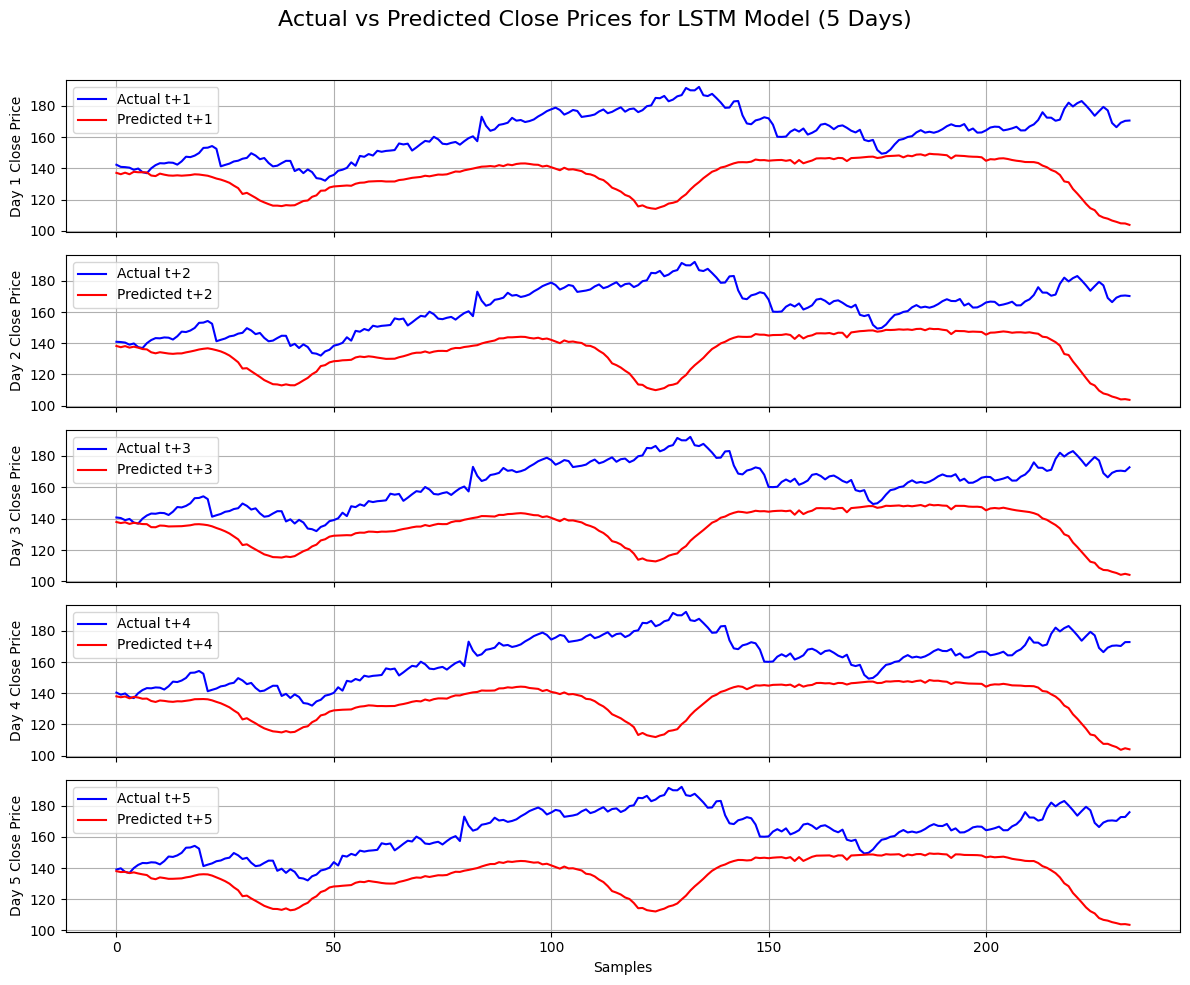

In [7]:
test_metrics = predict(lstm_model, test_loader, rnn_dataset)

In [8]:
metrics['model'].append(f'{lstm_model}')
metrics['train_loss'].append(train_loss.item())
metrics['test_loss'].append(test_loss.item())
for metric in test_metrics.keys():
    metrics[metric].append(test_metrics[metric])

In [9]:
model_fname = lstm_model.save_model_state(ticker_interval=f'{ticker}_{interval}')
model_fname

'GOOG_1d_LSTM_14885_5.pth'

## Train ConvLSTM model

In [10]:
from tradeforecast.forecast import ConvLSTM

clstm_kwargs = {'input_size': len(rnn_dataset.features),
            'conv_out_size': len(rnn_dataset.features)*2,
            'kernel_size': rnn_dataset.forecast_len,
            'hidden_size': 64,
            'n_LSTM': 2,
            'bidirectional': False,
            'fc_out_size':[],
            'output_size': rnn_dataset.forecast_len,
            'dropout': 0.01,
            'criterion': F.mse_loss,
            'lr': 0.1,
            'optimizer': optim.SGD}

clstm_model = ConvLSTM(**clstm_kwargs)

clstm_logger = TensorBoardLogger(save_dir=logs_dir, name=f'{clstm_model}', version='final')
clstm_trainer = Trainer(fast_dev_run=False, max_epochs=epochs, log_every_n_steps=10, check_val_every_n_epoch=100, logger=clstm_logger)

clstm_trainer.fit(clstm_model, train_dataloaders=train_loader, val_dataloaders=test_loader)

train_loss: Tensor = clstm_trainer.callback_metrics.get('train/loss', None)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type        | Params | Mode 
--------------------------------------------------
0 | conv1d    | Conv1d      | 2.3 K  | train
1 | bnorm     | BatchNorm1d | 60     | train
2 | avg_pool  | AvgPool1d   | 0      | train
3 | lstm      | LSTM        | 57.9 K | train
4 | fc_linear | Sequential  | 325    | train
--------------------------------------------------
60.5 K    Trainable params
0         Non-trainable params
60.5 K    Total params
0.242     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


Epoch 999: 100%|██████████| 17/17 [00:00<00:00, 31.41it/s, v_num=inal, train/loss=0.00155, step=999.0, lr=1e-5, val/loss=0.0719]    

`Trainer.fit` stopped: `max_epochs=1000` reached.


Epoch 999: 100%|██████████| 17/17 [00:00<00:00, 31.12it/s, v_num=inal, train/loss=0.00155, step=999.0, lr=1e-5, val/loss=0.0719]


In [11]:
clstm_trainer.test(clstm_model, test_loader)

test_loss: Tensor = clstm_trainer.callback_metrics.get('test/loss', None)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 190.95it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test/loss           0.0719251036643982
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


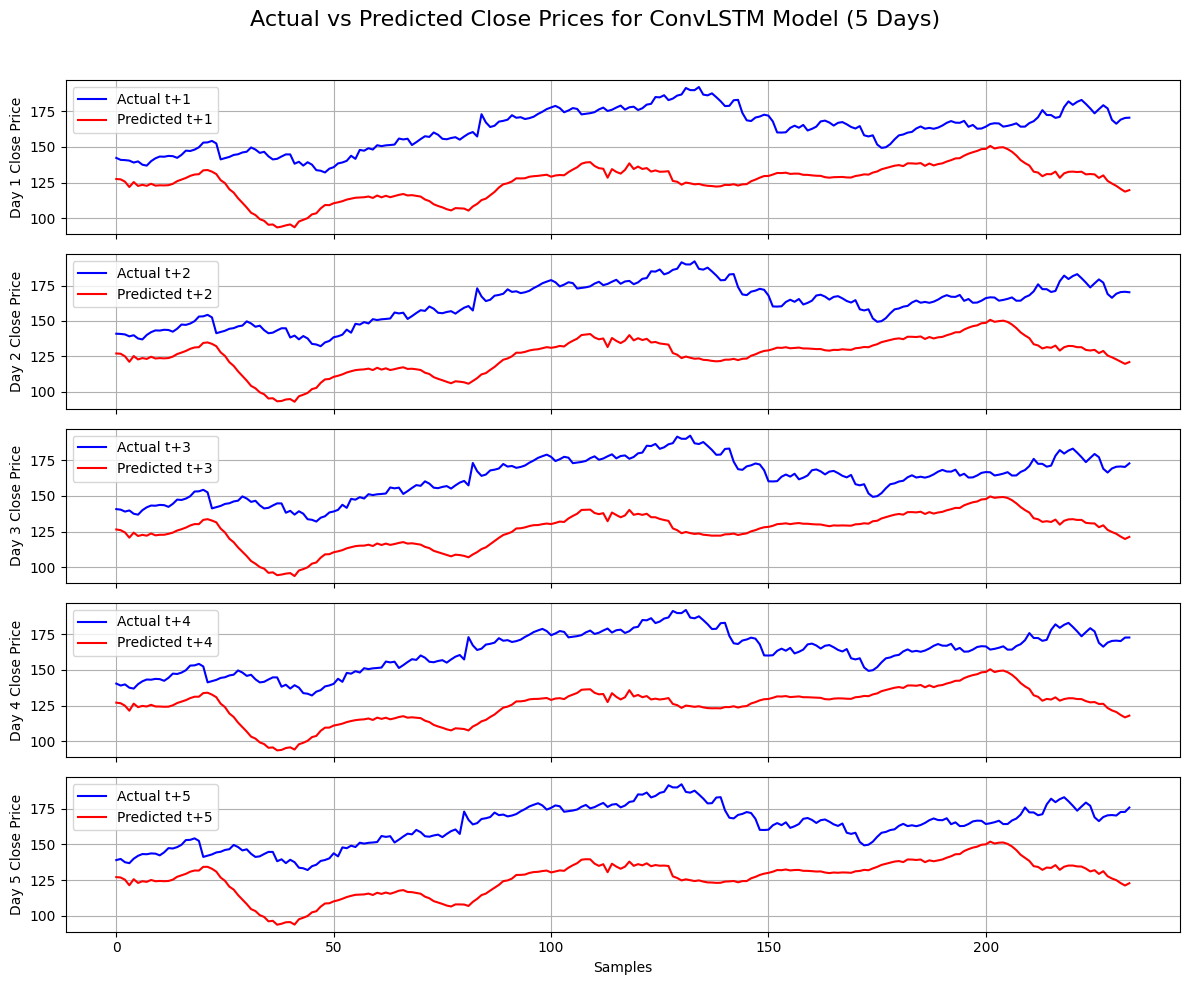

In [12]:
test_metrics = predict(clstm_model, test_loader, rnn_dataset)

In [13]:
metrics['model'].append(f'{clstm_model}')
metrics['train_loss'].append(train_loss.item())
metrics['test_loss'].append(test_loss.item())
for metric in test_metrics.keys():
    metrics[metric].append(test_metrics[metric])

In [14]:
model_fname = clstm_model.save_model_state(ticker_interval=f'{ticker}_{interval}')
model_fname

'GOOG_1d_ConvLSTM_60521_5.pth'

## Train EncTransformer Model

In [15]:
from tradeforecast.forecast import EncTransformer

et_kwargs = {'input_size': len(rnn_dataset.features),
            'nhead': 4,
            'd_model': 64,
            'num_layers': 2,
            'output_size': rnn_dataset.forecast_len,
            'dropout': 0,
            'criterion': F.mse_loss,
            'lr': 0.1,
            'optimizer': optim.SGD}

et_model = EncTransformer(**et_kwargs)

et_logger = TensorBoardLogger(save_dir=logs_dir, name=f'{et_model}', version='final')
et_trainer = Trainer(fast_dev_run=False, max_epochs=epochs, log_every_n_steps=10, check_val_every_n_epoch=100, logger=et_logger)

et_trainer.fit(et_model, train_dataloaders=train_loader, val_dataloaders=test_loader)

train_loss: Tensor = et_trainer.callback_metrics.get('train/loss', None)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type               | Params | Mode 
-------------------------------------------------------------------
0 | input_layer         | Linear             | 1.0 K  | train
1 | positional_encoding | PositionalEncoding | 0      | train
2 | encoder             | TransformerEncoder | 562 K  | train
3 | output_layer        | Linear             | 325    | train
-------------------------------------------------------------------
563 K     Trainable params
0         Non-trainable params
563 K     Total params
2.255     Total estimated model params size (MB)
26        Modules in train mode
0         Modules in eval mode


Epoch 999: 100%|██████████| 17/17 [00:00<00:00, 21.55it/s, v_num=inal, train/loss=0.00141, step=999.0, lr=0.0125, val/loss=0.101]

`Trainer.fit` stopped: `max_epochs=1000` reached.


Epoch 999: 100%|██████████| 17/17 [00:00<00:00, 21.38it/s, v_num=inal, train/loss=0.00141, step=999.0, lr=0.0125, val/loss=0.101]


In [16]:
et_trainer.test(et_model, test_loader)

test_loss: Tensor = et_trainer.callback_metrics.get('test/loss', None)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 104.39it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test/loss           0.1014544665813446
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


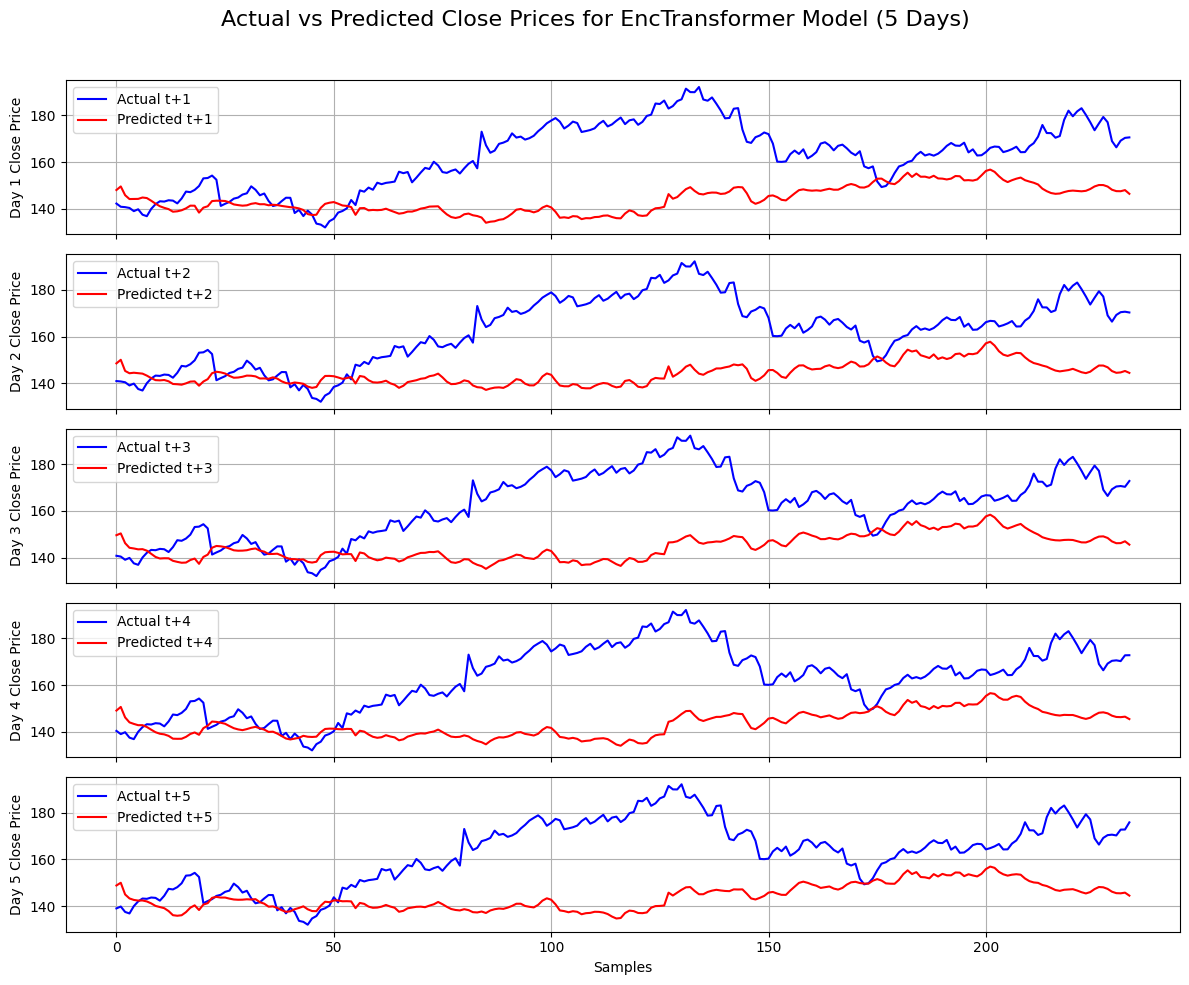

In [17]:
test_metrics = predict(et_model, test_loader, rnn_dataset)

In [18]:
metrics['model'].append(f'{et_model}')
metrics['train_loss'].append(train_loss.item())
metrics['test_loss'].append(test_loss.item())
for metric in test_metrics.keys():
    metrics[metric].append(test_metrics[metric])

In [19]:
model_fname = et_model.save_model_state(ticker_interval=f'{ticker}_{interval}')
model_fname

'GOOG_1d_EncTransformer_563653_5.pth'

In [20]:
import pandas as pd

metrics_df = pd.DataFrame(metrics)
metrics_df

,model,train_loss,test_loss,MAE,MSE,RMSE,R-squared
0,LSTM,0.003323,0.206343,0.377850,0.203770,0.451409,-4.413856
1,ConvLSTM,0.001545,0.071925,0.501648,0.283880,0.532804,-6.540868
2,EncTransformer,0.001410,0.101454,0.262689,0.101766,0.319008,-1.703956
